<a href="https://colab.research.google.com/github/FranklinFrostt/PortfolioProjects/blob/main/Diabetes_Prediction_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# In first cell
!wget https://raw.githubusercontent.com/plotly/datasets/master/diabetes.csv
import pandas as pd
df = pd.read_csv('diabetes.csv')


--2025-03-04 11:26:40--  https://raw.githubusercontent.com/plotly/datasets/master/diabetes.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23873 (23K) [text/plain]
Saving to: ‘diabetes.csv’

diabetes.csv        100%[===================>]  23.31K  --.-KB/s    in 0.001s  

2025-03-04 11:26:40 (31.5 MB/s) - ‘diabetes.csv’ saved [23873/23873]



       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   11.760232    0.476951  
min      0.000000                  

<Axes: xlabel='Outcome', ylabel='count'>

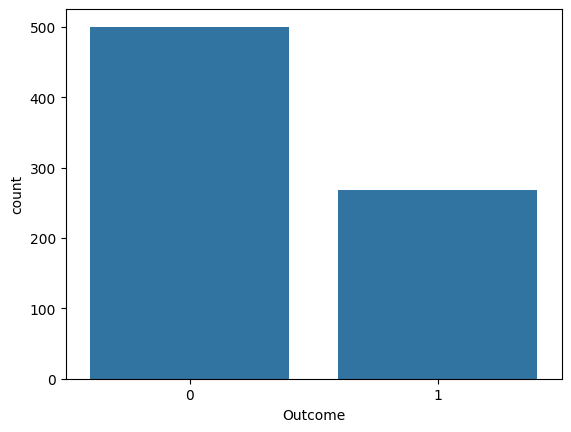

In [2]:
# Basic stats
print(df.describe())

# Check missing values
print(df.isnull().sum())

# Class distribution
import seaborn as sns
sns.countplot(x='Outcome', data=df)


In [25]:
# ========== SECTION 1: DATA VALIDATION ==========
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset (already downloaded)
df = pd.read_csv('diabetes.csv')

# Initial validation
print("=== INITIAL DATA SHAPE ===")
print(f"Original dataset shape: {df.shape}\n")

print("=== ZERO VALUE ANALYSIS ===")
zero_fields = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
zero_counts = df[zero_fields].apply(lambda x: (x == 0).sum())
print(zero_counts.to_string())

=== INITIAL DATA SHAPE ===
Original dataset shape: (768, 9)

=== ZERO VALUE ANALYSIS ===
Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11


In [26]:
# ========== SECTION 2: DATA PREPROCESSING ==========
# Handle zero values
imputation_strategy = {
    'Glucose': df['Glucose'].median(),
    'BloodPressure': df['BloodPressure'].median(),
    'SkinThickness': df['SkinThickness'].median(),
    'Insulin': df['Insulin'].median(),
    'BMI': df['BMI'].median()
}

for col, value in imputation_strategy.items():
    df[col] = df[col].replace(0, value)

# Validate zero correction
print("\n=== POST-IMPUTATION ZEROS ===")
print(df[zero_fields].apply(lambda x: (x == 0).sum()).to_string())


=== POST-IMPUTATION ZEROS ===
Glucose          0
BloodPressure    0
SkinThickness    0
Insulin          0
BMI              0


In [27]:
# ========== SECTION 3: FEATURE ENGINEERING ==========
# Create clinical ratios
epsilon = 1e-8  # Prevent division by zero
df['Glucose_Insulin_Ratio'] = df['Glucose'] / (df['Insulin'] + epsilon)
df['BP_Glucose_Ratio'] = df['BloodPressure'] / (df['Glucose'] + epsilon)
df['BMI_Age'] = df['BMI'] * df['Age']

# Validate new features
print("\n=== NEW FEATURE STATS ===")
print(df[['Glucose_Insulin_Ratio', 'BP_Glucose_Ratio', 'BMI_Age']].describe().loc[['mean', 'std']].round(2))


=== NEW FEATURE STATS ===
      Glucose_Insulin_Ratio  BP_Glucose_Ratio  BMI_Age
mean                   2.52              0.63  1080.78
std                    1.70              0.17   437.77


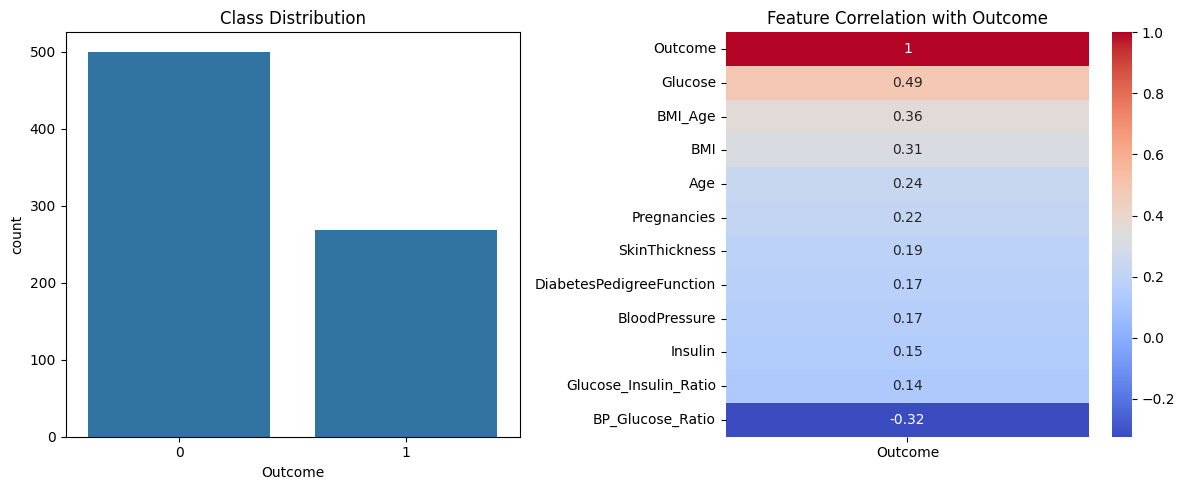

In [28]:
# ========== SECTION 4: DATA VISUALIZATION ==========
plt.figure(figsize=(12, 5))

# Class distribution
plt.subplot(1, 2, 1)
sns.countplot(x='Outcome', data=df)
plt.title('Class Distribution')

# Feature correlation
plt.subplot(1, 2, 2)
sns.heatmap(df.corr()[['Outcome']].sort_values('Outcome', ascending=False),
           annot=True, cmap='coolwarm')
plt.title('Feature Correlation with Outcome')
plt.tight_layout()
plt.show()


In [29]:
# ========== SECTION 5: MODEL PREPARATION ==========
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

X = df.drop('Outcome', axis=1)
y = df['Outcome']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Handle class imbalance
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

print("\n=== DATA SPLIT SHAPES ===")
print(f"Training set: {X_train_scaled.shape}")
print(f"Testing set: {X_test_scaled.shape}")


=== DATA SPLIT SHAPES ===
Training set: (800, 11)
Testing set: (154, 11)


In [30]:
# ========== SECTION 6: MODEL TRAINING ==========
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Hyperparameter tuning
params = {
    'n_estimators': [200, 300],
    'max_depth': [5, 10, None],
    'class_weight': ['balanced', None]
}

rf = RandomForestClassifier(random_state=42)
grid = GridSearchCV(rf, params, cv=5, scoring='recall')
grid.fit(X_train_scaled, y_train_res)

print("\n=== BEST PARAMETERS ===")
print(grid.best_params_)


=== BEST PARAMETERS ===
{'class_weight': 'balanced', 'max_depth': 10, 'n_estimators': 300}


In [31]:
# ========== SECTION 7: MODEL EVALUATION ==========
from sklearn.metrics import classification_report, confusion_matrix

best_model = grid.best_estimator_
y_pred = best_model.predict(X_test_scaled)

print("\n=== TEST SET PERFORMANCE ===")
print(classification_report(y_test, y_pred))

# Feature importance
feature_importance = pd.Series(best_model.feature_importances_, index=X.columns)
top_features = feature_importance.sort_values(ascending=False).head(5)

print("\n=== TOP 5 FEATURES ===")
print(top_features.to_string())



=== TEST SET PERFORMANCE ===
              precision    recall  f1-score   support

           0       0.85      0.80      0.82       100
           1       0.67      0.74      0.70        54

    accuracy                           0.78       154
   macro avg       0.76      0.77      0.76       154
weighted avg       0.79      0.78      0.78       154


=== TOP 5 FEATURES ===
Glucose                     0.183816
BMI_Age                     0.160975
BMI                         0.133179
BP_Glucose_Ratio            0.102832
DiabetesPedigreeFunction    0.091213


In [32]:
# ========== SECTION 8: DEPLOYMENT PREP ==========
import joblib

# Save artifacts
joblib.dump(best_model, 'diabetes_rf_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

print("\n=== DEPLOYMENT ARTIFACTS SAVED ===")
print("Model file: diabetes_rf_model.pkl")
print("Scaler file: scaler.pkl")


=== DEPLOYMENT ARTIFACTS SAVED ===
Model file: diabetes_rf_model.pkl
Scaler file: scaler.pkl
